In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report, precision_score, recall_score, f1_score

In [ ]:
def plot_hist(hist):
    plt.figure(figsize=(20,20))
    fig, axs = plt.subplots(2)
    
    axs[0].plot(hist.history["accuracy"], label="Train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="Test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(hist.history["loss"], label="Train error")
    axs[1].plot(hist.history["val_loss"], label="Test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.tight_layout()
    plt.show()

In [ ]:
def prepare_dataset(test_size, validation_size):
    inputs_ = np.loadtxt("/content/drive/MyDrive/inputs_mfcc.txt")
    X = inputs_.reshape(inputs_.shape[0], inputs_.shape[1] // 13, 13)
    y = np.loadtxt("/content/drive/MyDrive/targets_mfcc.txt")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

def plot_cf_matrix(cf_matrix, title):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(genres, rotation=90)
    ax.yaxis.set_ticklabels(genres, rotation=0)
    plt.show()

In [ ]:
train_dir = "/content/drive/MyDrive/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/drive/MyDrive/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128, shuffle=False)
test_steps_per_epoch = np.math.ceil(vali_generator.samples / vali_generator.batch_size)

Found 8990 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
model = Sequential([
    # The first convolution
    Conv2D(8, kernel_size=(3,3), strides=(1,1), activation="relu", input_shape=(288,432,4), kernel_regularizer=regularizers.l2(l=0.01)),
    BatchNormalization(axis=3),
    MaxPooling2D(2, 2),
    Dropout(rate=0.05),
    # The second convolution
    Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
    BatchNormalization(axis=3),
    MaxPooling2D(2,2),    
    Dropout(rate=0.1),
    # The third convolution
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
    BatchNormalization(axis=3),
    MaxPooling2D(2,2),
    Dropout(rate=0.2),
    # The fourth convolution
    Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
    BatchNormalization(axis=-1),
    MaxPooling2D(2,2),
    Dropout(rate=0.3),
    # The fifth convolution
    Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
    BatchNormalization(axis=-1),
    MaxPooling2D(2,2),
    Dropout(rate=0.3),
    # Flatten the results to feed into a DNN
    Flatten(),
    # Dropout
    Dropout(rate=0.3),
    # Dense
    Dense(10, activation='softmax', name='fc10')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 286, 430, 8)       296       
                                                                 
 batch_normalization_10 (Bat  (None, 286, 430, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 143, 215, 8)      0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 143, 215, 8)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 141, 213, 16)      1168      
                                                                 
 batch_normalization_11 (Bat  (None, 141, 213, 16)    

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [ ]:
hist = model.fit(train_generator,
                 validation_data = vali_generator,
                 epochs = 50)

Epoch 1/50
71/71 [==============================] - 93s 1s/step - loss: 5.3338 - accuracy: 0.2081 - val_loss: 4.3734 - val_accuracy: 0.1000
Epoch 2/50
71/71 [==============================] - 86s 1s/step - loss: 4.0453 - accuracy: 0.3483 - val_loss: 5.1932 - val_accuracy: 0.1780
Epoch 3/50
71/71 [==============================] - 85s 1s/step - loss: 3.4981 - accuracy: 0.4343 - val_loss: 5.5608 - val_accuracy: 0.1000
Epoch 4/50
71/71 [==============================] - 85s 1s/step - loss: 3.1339 - accuracy: 0.4914 - val_loss: 7.2573 - val_accuracy: 0.1000
Epoch 5/50
71/71 [==============================] - 87s 1s/step - loss: 2.8747 - accuracy: 0.5382 - val_loss: 6.5756 - val_accuracy: 0.1610
Epoch 6/50
71/71 [==============================] - 87s 1s/step - loss: 2.6867 - accuracy: 0.5622 - val_loss: 6.0511 - val_accuracy: 0.2050
Epoch 7/50
71/71 [==============================] - 87s 1s/step - loss: 2.4825 - accuracy: 0.5998 - val_loss: 5.2904 - val_accuracy: 0.2320
Epoch 8/50
71/71 [==

<Figure size 1440x1440 with 0 Axes>

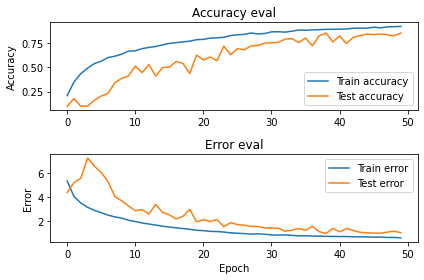

In [ ]:
plot_hist(hist)

In [ ]:
predictions = model.predict(vali_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

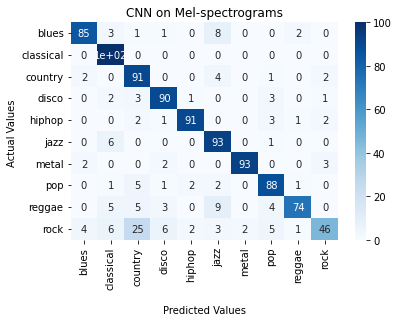

CA: 0.851; Precision: 0.862; Recall: 0.851; F1-score: 0.846


In [ ]:
true_classes = vali_generator.classes
class_labels = list(vali_generator.class_indices.keys())

cf_matrix = confusion_matrix(true_classes, predicted_classes)
plot_cf_matrix(cf_matrix, "CNN on Mel-spectrograms")

ca = accuracy_score(true_classes, predicted_classes)
p = precision_score(true_classes, predicted_classes, average=None)
r = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

print("CA: %.3f; Precision: %.3f; Recall: %.3f; F1-score: %.3f" % (ca, np.mean(p), np.mean(r), np.mean(f1)))

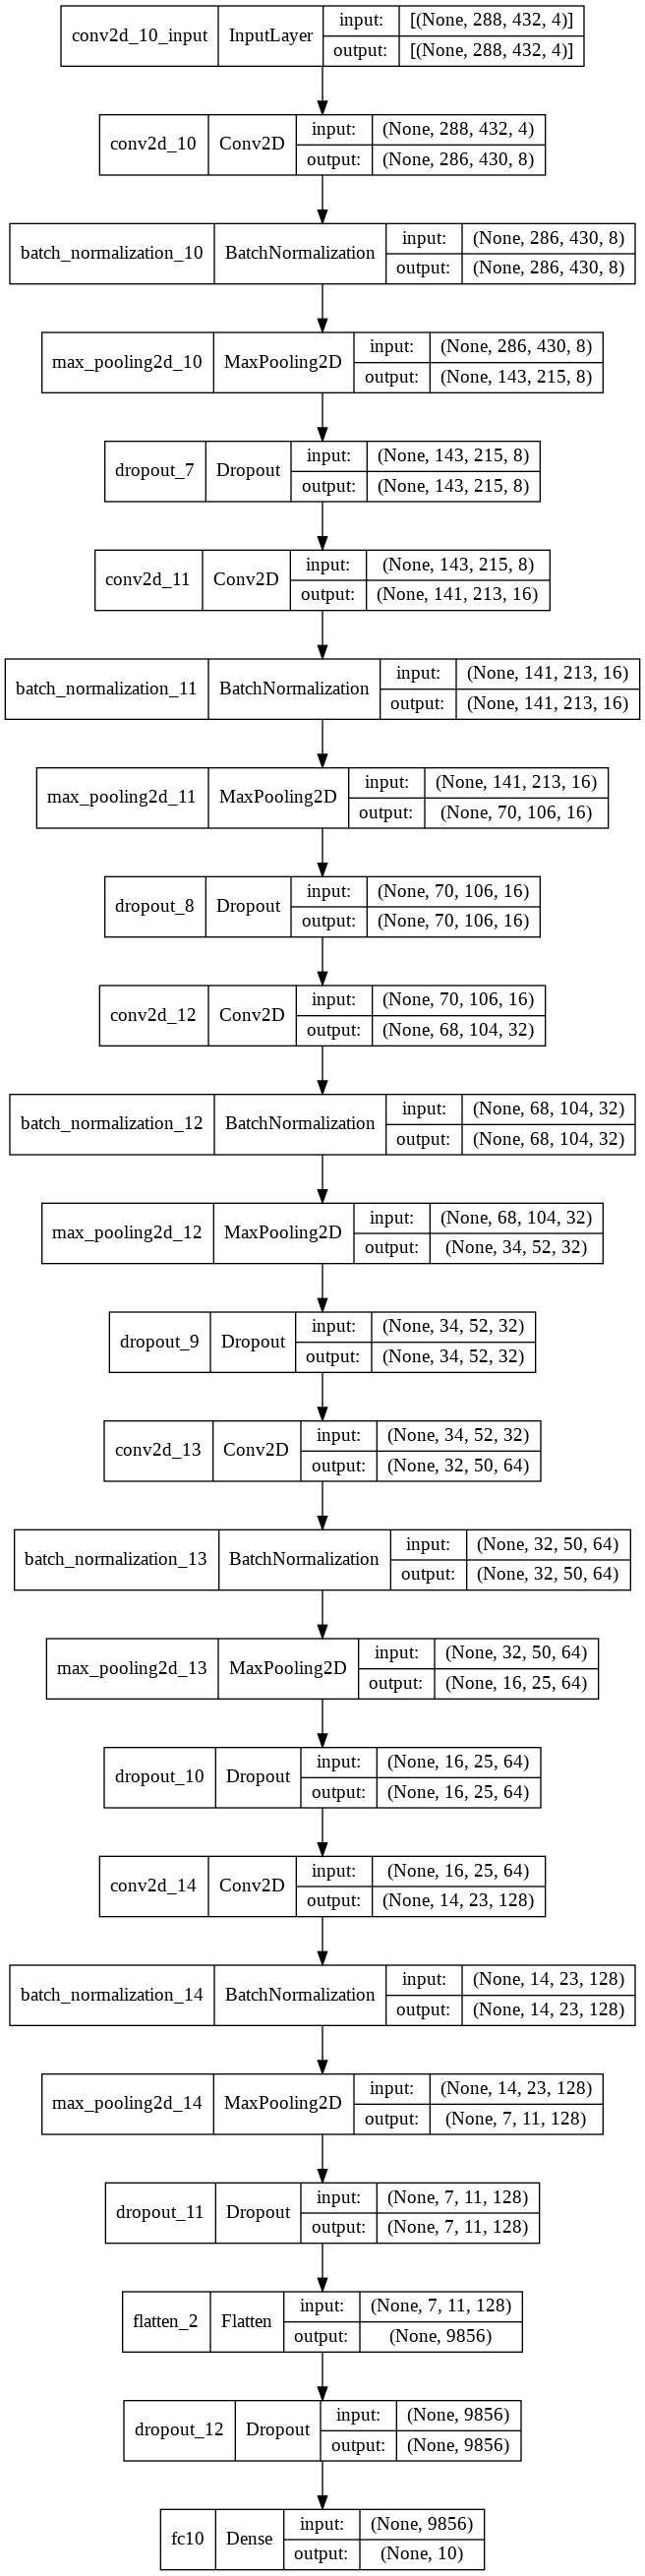

In [ ]:
keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)